# 4ab Creating a Multigrid Poisson Solver
Multigrid solvers are built on a few key observations:
  * Iterative solvers, like the Jacobi solver, correct the small scale errors of a solution faster than the large scale errors
  * The solution to the Poisson equation can be used to formulate an analogous equation for the solution of the error term
  * By using a __restriction operator__ we can solve the equation for the error term on a coarse mesh
  * By using a __prolongation operator__ we can propogate the solution for the error term from the coarse to the fine mesh
  * This can be done recursively
  * Solving on the coarse mesh is cheaper by a factor 2^ndim

In this exercise you will get the chance to build a nice recursive piece of code by yourself and create a multigrid solver. Below are only given the logical pieces, the rest you have to create.

_This exercise counts for the full week_

## Preparation:
At the bottom write a section heading, "Solution", and copy the multigrid class and the small piece of to run the solver below it. This gives you a clean reference code above, and makes it easier to see what has been modified.

#### Task 1 (40 pt):  
Create the prolongation and restriction operators, and the central recursive algorithm (see the code below).

#### Task 2 (40 pt):
Validate the solver. Multigrid solvers have the central property that, for a given tolerance, the number of needed multigrid cycles only depends weakly on the resolution
Compare with a simple Jacobi integrator. Notice the ```maxit```option that may have to be increased for it to converge, if you go to high resolutions.

#### Task 3 (20 pt):
Timing: at what resolution does your multigrid solver become faster than the Jacobi solver?

#### Extra open task  (up to 20 pt):
The convergence properties of a multi grid solver can be be improved by not doing the full cycle up and down (V-cycle), but instead first going all the way down, then half way up, down again, and then all the way up (W-cycle). Change the solver to a W-cycle, or explore other cycle configurations (see e.g. the link at the end of the slides). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import images as im
from time import time
np.set_printoptions(linewidth=120)
from scipy.interpolate import griddata

### Hydro data class and initial conditions

In [2]:
class HD():
    def __init__(u,n=(32,32,32),nv=1,gamma=1.4,cs=1.,G=1.,L=2.0,d0=1.):
        # make n a 3-tuple if given as an integer
        if isinstance(n, int):
            m = (n,n,n)
        else:
            m = n
        u.n = m                             # resolution of the grid is (n[1],n[2],n[3])
        u.it= 0                             # number of updates (integer)
        u.t = 0.0                           # Time
        u.nv = nv                           # number of variables. We use nv = 8 = (density, total energy, momentum[xyz], magnetic field[xyz])
        u.ndim = 3                          # dimensionality of the experiment
        u.G     = G                         # Newtons constant of gravity
        u.var   = np.zeros((nv,)+m)         # conserved variables. "(nv,)+m gives a 4-tuple with (nv,n[0],n[1],n[2])"
        u.D     = u.var[0]                  # mass density pointer
        u.D[:,:,:] = d0                     # constand density
        u.coordinates(n=m,L=L)              # define coordinate system
        u.varnames=np.array(('D'))
        
    def coordinates(u,n,L=2.0):             # function to define coordinates
        # make cell centered coordinates with domain boundaries [-L:L]^ndim
        u.ds = L / n[0]                     # cell size
        LL = 0.5*u.ds*n[0], 0.5*u.ds*n[1], 0.5*u.ds*n[2]
        u.x = np.linspace(-LL[0],LL[0],n[0], endpoint=False) + 0.5 * u.ds # cell centered coordinates
        u.y = np.linspace(-LL[1],LL[1],n[1], endpoint=False) + 0.5 * u.ds
        u.z = np.linspace(-LL[2],LL[2],n[2], endpoint=False) + 0.5 * u.ds
        u.coords = np.array(np.meshgrid(u.x,u.y,u.z,indexing='ij')) # expand to 3D grid
        u.r = np.sqrt(np.sum(u.coords[0:3]**2,axis=0)) # spherical radius
        u.L = 2.*np.array(LL)               # box size
        u.n = n                             # number of grid points

def BonnorEbert(n=32,r0=0.5,rc=0.1):
    """ Simple 1/(r+rc)^2 for r < r0 density distribution """
    u=HD(n=n)
    u.D[:,:,:] = 0.
    ii = np.where(u.r <= r0)
    u.D[ii] = 1. / (u.r[ii]+rc)**2
    return u

### Jacobi solver and computation of residual

In [3]:
def Jacobi_residual(Phi,S):
    """ calculate explicit residual for given Phi, S """
    n = Phi.shape        # grid size
    res = np.copy(S)
    for i in range(3):
        if n[i] > 1:
            res += (np.roll(Phi,+1,axis=i)+np.roll(Phi,-1,axis=i)) - 2.*Phi
    # fix boundaries
    if n[0] > 2:
        res[0,:,:] = res[-1,:,:] = 0.
    if n[1] > 2:
        res[:,0,:] = res[:,-1,:] = 0.
    if n[2] > 2:
        res[:,:,0] = res[:,:,-1] = 0.
    return res

def Jacobi(Phi,S):
    """ Jacobi iteration for multi-grid self-gravity """
    n = Phi.shape  # grid size

    const = 0.     # Prefactor for normalising dimensions (2 * ndim)
    #   phi = 1/(2ndim) (phi(i-1,j,k)+phi(i+1,j,k)+... - 4 pi G ds^2 rho)
    #   Pad Phi with zeros in each direction for boundary values (assumed to be zero) using numpy.pad
    Phi_new = np.copy(S)   # copy source
    if n[0] > 1:
        const += 2.
        PP = np.pad(Phi, ((1,1),(0,0),(0,0)), 'constant', constant_values=(0., 0.))
        Phi_new += (np.roll(PP,+1,axis=0)+np.roll(PP,-1,axis=0))[1:-1,:,:]
    if n[1] > 1:
        const += 2.
        PP = np.pad(Phi, ((0,0),(1,1),(0,0)), 'constant', constant_values=(0., 0.))
        Phi_new += (np.roll(PP,+1,axis=1)+np.roll(PP,-1,axis=1))[:,1:-1,:]
    if n[2] > 1:
        const += 2.
        PP = np.pad(Phi, ((0,0),(0,0),(1,1)), 'constant', constant_values=(0., 0.))
        Phi_new += (np.roll(PP,+1,axis=2)+np.roll(PP,-1,axis=2))[:,:,1:-1]

    Phi_new *= (1./const) # normalise

    # Return solution and residual (Phi_new - Phi = S + Laplace Phi)
    return Phi_new, Phi_new - Phi

### Iterative Jacobi solver for selfgravity

In [4]:
class poisson():
    def __init__(self, u, tolerance=1e-4,maxit=2000):
        """ Initialize a Poisson solver """
        self.n         = u.n       # Mesh size
        self.maxit     = maxit     # Maximum number of iterative steps to take
        self.tolerance = tolerance # Tolerance to satisfy for the error

    # Iterative Solver for the Poisson Problem
    def Poisson(self,u):
        S = -(4.*np.pi*u.G)*u.D*u.ds**2
        norm   = np.amax(np.abs(S))
        Phi = np.zeros(self.n)        # Start guess =0
        self.it = 0; self.error = self.tolerance
        while self.error >= self.tolerance and self.it<self.maxit:
            Phi, residual = Jacobi(Phi,S)
            self.error = np.amax(np.abs(residual) / norm)
            self.it+=1
            
        residual = Jacobi_residual(Phi,S)
                    
        return Phi, self.it, self.error, residual

### Driver for calling the Jacobi solver

Nr of iterations, error, tolerance : 992 9.98e-05 1.0e-04
Time = 0.9 seconds, 28.4 musec/cell, 28.7 nanosec/cell/it


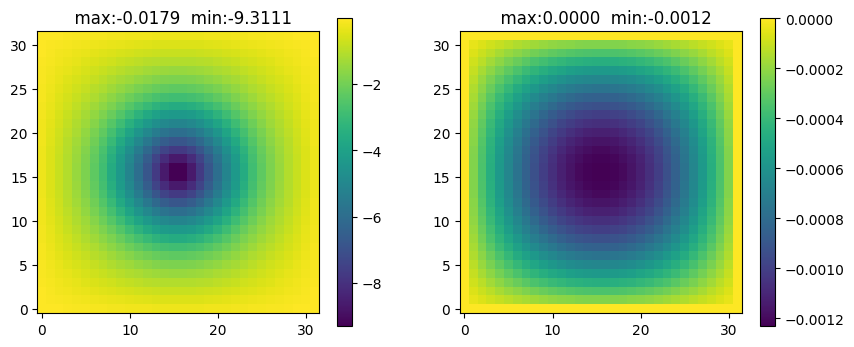

In [5]:
u = BonnorEbert(n=32,rc=0.1, r0=0.5)
P = poisson(u,maxit=8000)

start = time()
Phi, nt, err, res = P.Poisson(u)
used = time() - start
ntot = u.n[0]*u.n[1]*u.n[2]
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(nt, err, P.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(used,1e6*used/ntot,1e9*used/(ntot*nt)))

# Show solution, Phi, and residual, res, side-by-side
im.imshows(np.array( [Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

### Investigating the solution

Plot the size of the potential, $\Phi$, as a function of distance from center $r$. Notice how it strays from a perfect spherical solution because we restrict it to be zero on the boundary

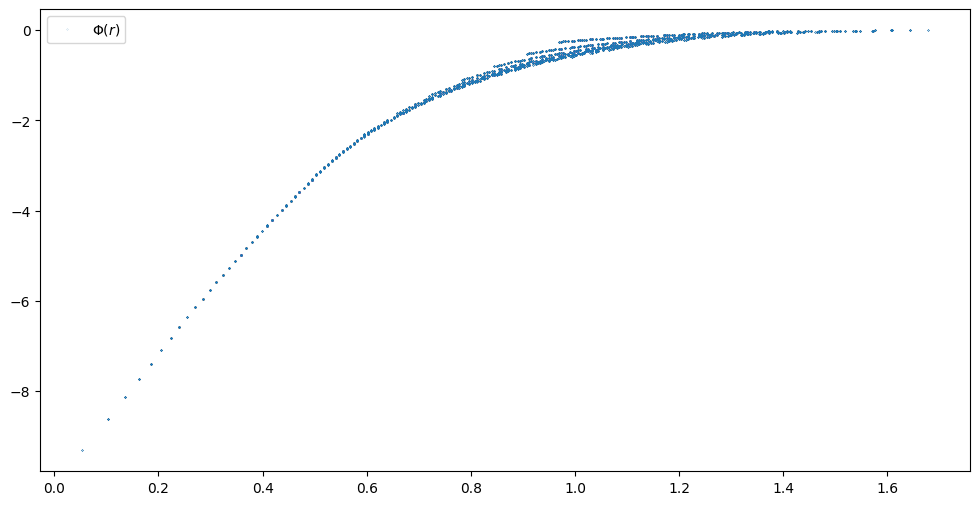

In [6]:
f = plt.figure(figsize=(12,6))
plt.plot(u.r.ravel(),Phi.ravel(),'o',markersize=0.1,label=r'$\Phi(r)$')
plt.legend();

### Multigrid Solver

Make a Multigrid solver class / object, which given a hydro object finds the solution for the potential

In [7]:
class Multigrid():
    def __init__(self,u,tolerance=1e-5,maxit=200,itsmooth=1):
        """ initialize Poisson solver class for u """
        self.itsmooth = itsmooth    # How many Jacobi iteration to take on each level
        self.maxit = maxit          # maximum number multigrid iterations. Depends on tolerance
        self.tolerance = tolerance  # tolerance to satisfy for the error
        self.setup_grids(u.n)       # generate hierarchy of grids for multigrid cycle

    def setup_grids(self,n):
        """ setup the dimensions and allocate storage for solutions on multigrid meshes """
        nn = np.array(n)                   # convert dimensions to numpy array
        nm = [];  nm.append(np.copy(nn))   # store dimension of level
        Phi = []; Phi.append(np.zeros(nn)) # array to store solution for this level
        print("MG level, n:",0, nn) # Info
        while np.any(nn % 2 == 0):         # check if any dimension still is divisible by 2
            if np.all(nn <= 2):            # reached 2x2x2 problem, stop
                break
            ii = np.where(nn % 2 == 0) # check which dimensions we can reduce
            nn[ii] = nn[ii] / 2        # reduce
            nm.append(np.copy(nn))     # store in level structure
            Phi.append(np.zeros(nn))   # array to store solution at this level
            print ("MG level, n:", len(nm)-1, nn) # info
        # Store data structure in class
        self.level = len(nm)-1         # max level (zero-indexed)
        self.n     = nm                # mesh sizes
        self.Phi   = Phi               # current solution on each level

    def restrict(self,f_fine):
        """ restrict residual to coarser level by taking every second element """
        n = np.array(np.shape(f_fine))
        # calculate f_coarse and return it
        # ...
        return f_coarse
    
    def prolong(self,f_coarse,level):
        """ prolong solution to finer level by copy for every second point and average for every second point """
        
        return f_fine
    
    def solver(self,S,Phi):
        """ do itsmooth Jacobi iterations """
        for i in range(self.itsmooth):
            Phi[:,:,:], _ = Jacobi(Phi,S)
        residual = Jacobi_residual(Phi,S)
        return residual
    
    # The heart of the multigrid algorithm. This function should call itself recursively.
    # As given, it just updates Phi and solves for the residual twice, which
    # corrsponds to taking two times itsmooth Jacobi iterations
    def MGcycle(self,level,source):
        residual = self.solver(source,self.Phi[level])                 # iterate solution at this level

        if (level < self.level):     #while                                  # if not on coarsest level, recurse
            # 1. restrict *residual* from current level to coarse level (=level+1)
            # 2. call solve at coarser level (e.g. level+1)
            # 3. prolong the solution for Phi from the coarser level (=level+1) and add to solution on this level
            residual = self.solver(source,self.Phi[level])                 # iterate solution again at this level
        
    def full_solve(self,u):
        S = -(4.*np.pi*u.G)*u.D*u.ds**2
        norm   = np.amax(np.abs(S))                  # normalisation for residual
        self.it = 0
        self.error = self.tolerance
        # Main loop
        while self.error >= self.tolerance and self.it<self.maxit:
            self.MGcycle(0,S)                        # do a full multigrid cycle
            self.it += 1                             # inc nr of MG iterations
            res = Jacobi_residual(self.Phi[0],S)     # compute residual
            self.error = np.amax(np.abs(res) / norm) # estimate error
            
        return self.Phi[0], res

MG level, n: 0 [32 32 32]
MG level, n: 1 [16 16 16]
MG level, n: 2 [8 8 8]
MG level, n: 3 [4 4 4]
MG level, n: 4 [2 2 2]
Nr of iterations, error, tolerance : 693 9.97e-05 1.0e-04
Time = 2.4 seconds, 74.0 musec/cell, 74.6 nanosec/cell/it


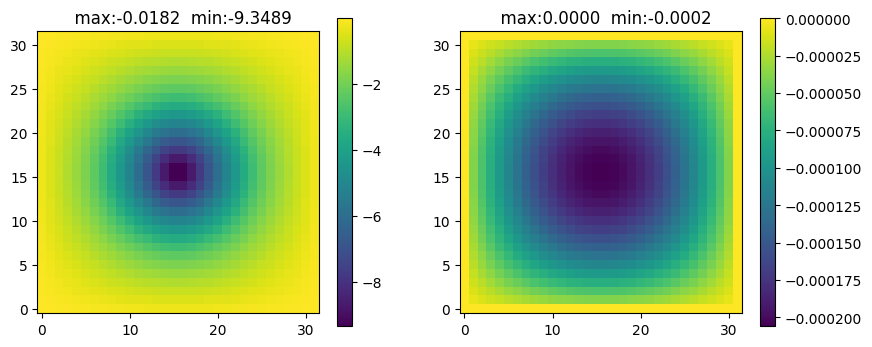

In [8]:
n=32
u = BonnorEbert(n=n,rc=0.1, r0=0.5)                    # Compute the density distribution
M = Multigrid(u,maxit=5000,itsmooth=1,tolerance=1e-4)  # Setup the Multigrid solver object

start = time()              # for timing
Phi, res = M.full_solve(u)  # call the multigrid solver
used = time() - start       # for timing

# print some statistics
ntot = u.n[0]*u.n[1]*u.n[2]
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(M.it, M.error, M.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(
    used,1e6*used/ntot,1e9*used/(ntot*nt)))
# show potetial and residual
im.imshows(np.array( [Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

----
#### Add your solution below

## Task 1

In [9]:
class Multigrid():
    def __init__(self,u,tolerance=1e-5,maxit=200,itsmooth=1):
        """ initialize Poisson solver class for u """
        self.itsmooth = itsmooth    # How many Jacobi iteration to take on each level
        self.maxit = maxit          # maximum number multigrid iterations. Depends on tolerance
        self.tolerance = tolerance  # tolerance to satisfy for the error
        self.setup_grids(u.n)       # generate hierarchy of grids for multigrid cycle

    def setup_grids(self,n):
        """ setup the dimensions and allocate storage for solutions on multigrid meshes """
        nn = np.array(n)                   # convert dimensions to numpy array
        nm = [];  nm.append(np.copy(nn))   # store dimension of level
        Phi = []; Phi.append(np.zeros(nn)) # array to store solution for this level
        print("MG level, n:",0, nn) # Info
        while np.any(nn % 2 == 0):         # check if any dimension still is divisible by 2
            if np.all(nn <= 2):            # reached 2x2x2 problem, stop
                break
            ii = np.where(nn % 2 == 0) # check which dimensions we can reduce
            nn[ii] = nn[ii] / 2        # reduce
            nm.append(np.copy(nn))     # store in level structure
            Phi.append(np.zeros(nn))   # array to store solution at this level
            print ("MG level, n:", len(nm)-1, nn) # info
        # Store data structure in class
        self.level = len(nm)-1         # max level (zero-indexed)
        self.n     = nm                # mesh sizes
        self.Phi   = Phi               # current solution on each level

    def restrict(self,f_fine):
        """ restrict residual to coarser level by taking every second element """
        n = np.array(np.shape(f_fine))
        f_coarse=f_fine[::2,::2,::2].copy() 
        '''
         #or someone can use the code above:
         nx = f_fine.shape[0]
         ny = f_fine.shape[1]
         nz = f_fine.shape[2]
         nnx=nx//2
         nny=ny//2
         nnz=nz//2
         fn=np.zeros((nnx,nny,nnz))
         for i in range(1,nnx):
             for j in range(1,nny):
                 for k in range(1,nnz):
                     fn[i][j][k]+=f_fine[i*2][j*2][k*2]
        '''
        return f_coarse
    
    def prolong(self,f_coarse,level):
        """ prolong solution to finer level by copy for every second point and average for every second point """
       
        return f_fine
    
    def solver(self,S,Phi):
        """ do itsmooth Jacobi iterations """
        for i in range(self.itsmooth):
            Phi[:,:,:], _ = Jacobi(Phi,S)
        residual = Jacobi_residual(Phi,S)
        return residual
    
    # The heart of the multigrid algorithm. This function should call itself recursively.
    # As given, it just updates Phi and solves for the residual twice, which
    # corrsponds to taking two times itsmooth Jacobi iterations
    def MGcycle(self,level,source):
        residual = self.solver(source,self.Phi[level])                 # iterate solution at this level

        if (level < self.level):                                       # if not on coarsest level, recurse
            
            
            # 1. restrict *residual* from current level to coarse level (=level+1)
            # 2. call solve at coarser level (e.g. level+1)
            # 3. prolong the solution for Phi from the coarser level (=level+1) and add to solution on this level

            residual = self.solver(source,self.Phi[level])                 # iterate solution again at this level
        
    def full_solve(self,u):
        S = -(4.*np.pi*u.G)*u.D*u.ds**2
        norm   = np.amax(np.abs(S))                  # normalisation for residual
        self.it = 0
        self.error = self.tolerance
        # Main loop
        while self.error >= self.tolerance and self.it<self.maxit:
            self.MGcycle(0,S)                        # do a full multigrid cycle
            self.it += 1                             # inc nr of MG iterations
            res = Jacobi_residual(self.Phi[0],S)     # compute residual
            self.error = np.amax(np.abs(res) / norm) # estimate error
            
        return self.Phi[0], res

MG level, n: 0 [32 32 32]
MG level, n: 1 [16 16 16]
MG level, n: 2 [8 8 8]
MG level, n: 3 [4 4 4]
MG level, n: 4 [2 2 2]
Nr of iterations, error, tolerance : 693 9.97e-05 1.0e-04
Time = 2.4 seconds, 74.7 musec/cell, 75.3 nanosec/cell/it


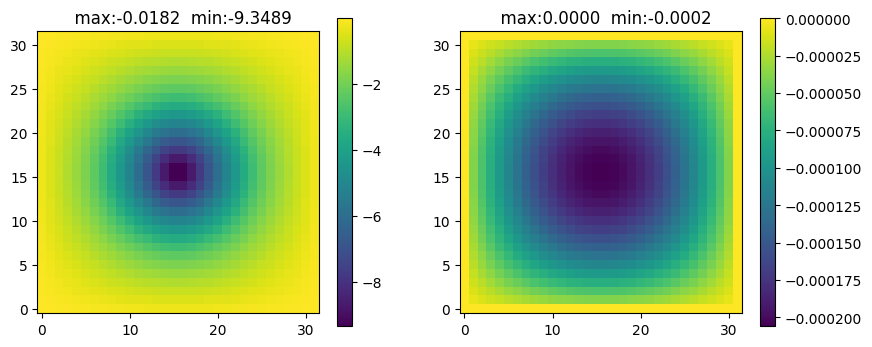

In [10]:
n=32
u = BonnorEbert(n=n,rc=0.1, r0=0.5)                    # Compute the density distribution
M = Multigrid(u,maxit=5000,itsmooth=1,tolerance=1e-4)  # Setup the Multigrid solver object

start = time()              # for timing
Phi, res = M.full_solve(u)  # call the multigrid solver
used = time() - start       # for timing

# print some statistics
ntot = u.n[0]*u.n[1]*u.n[2]
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(M.it, M.error, M.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(
    used,1e6*used/ntot,1e9*used/(ntot*nt)))
# show potetial and residual
im.imshows(np.array( [Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

#### restriction function

#### prolongation version 1

In [11]:
import scipy as sc

In [12]:
f_fine=res
n = np.array(np.shape(f_fine))
lv=2
print(np.shape(f_fine))
f1=f_fine[::lv,::lv,::lv].copy() 
print(np.shape(f1))


(32, 32, 32)
(16, 16, 16)


In [19]:
f_fine=res
def restrict(f_fine):
        """ restrict residual to coarser level by taking every second element """
        n = np.array(np.shape(f_fine))
        lv=2
        f_coarse=f_fine[::lv,::lv,::lv].copy() 
        return f_coarse

def prolong(f_coarse,level):
        """ prolong solution to finer level by copy for every second point and average for every second point """
        n2=np.array(np.shape(f_coarse))
        s=2
        nni, nnj, nnk = n2[0]*s, n2[1]*s, n2[2]*s
        fnn=np.zeros((nni,nnj,nnk))
        #We copy every second element to our new grid. The above procedure is for even number of matrices
        fnn[::2,::2,::2]=f_coarse[::1,::1,::1] 
        #Fill odd number of columns for even numbers of rows with the average of the neighbouring values-the last space of the row is empty
        for i in range(0,nni,2): 
            for j in range(0,nnj,2):
                for k in range(1,nnk-1,2):
                    fnn[i,j,k]=0.5*(fnn[i,j,k-1]+fnn[i,j,k+1]) 
        #Fill the last space on the even number of rows
        for i in range(0,nni,2):
            for j in range(0,nnj,2):
                fnn[i][j][nnj-1]=0.5*(fnn[i][j][nnj-2]+fnn[i][j][0]) 
        #Fill the elements which belongs to odd number of rows and even number of columns
        for i in range(0,nni,2): 
            for j in range(1,nnj-1,2):
                for k in range(0,nnk,2):
                    fnn[i,j,k]=0.5*(fnn[i,j-1,k]+fnn[i,j+1,k])
        #Fill the element at the last column, for odd number of row, by averaging the above and below values. The above and below values have been calcuated
        # when filling the last spave on the even number of rows
        for i in range(0,nni,2): 
            for j in range(1,nnj-1,2):
                fnn[i,j,nnk-1]=0.5*(fnn[i,j-1,nnk-1]+fnn[i,j+1,nnk-1])
        #Fill the last empty row, we average the prelast and the first element        
        for i in range(0,nni,2): 
            for k in range(nnk):
                fnn[i,nnj-1,k]=0.5*(fnn[i,nnj-2,k]+fnn[i,0,k])
        #Fill the value being in the diagonal with odd coordinates. We average the neighbour values by creating a cross.
        for i in range(0,nni,2): 
            for j in range(1,nnj-1,2):
                for k in range(1,nnk-1,2):
                    fnn[i,j,k]=0.5*(fnn[i,j-1,k]+fnn[i,j+1,k])+0.5*(fnn[i,j,k-1]+fnn[i,j,k+1])
        #Find the odd number of matrices, simply add the previous and the next one as we did in the elemtns
        for i in range(1,nni-1,2):
            for j in range(0,nnj):
                for k in range(0,nnk):
                    fnn[i,j,k]=0.5*(fnn[i-1,j,k]+fnn[i+1,j,k])
        #For the last matrix, we do the same procedure as we did in the elements
        for j in range(0,nnj):
                for k in range(0,nnk):
                    fnn[nni-1,j,k]=0.5*(fnn[nni-2,j,k]+fnn[0,j,k])
            
                                          
        f_fine=fnn.copy()                          
        return f_fine
    
    



In [26]:
f1=restrict(f_fine)
fp=prolong(f1,1)
print(fp[3][1])



[ 0.00000000e+00 -3.03658439e-06 -3.03658439e-06 -7.97546524e-06 -4.93888085e-06 -1.16015542e-05 -6.66267338e-06
 -1.48083330e-05 -8.14565964e-06 -1.74799002e-05 -9.33424060e-06 -1.95196984e-05 -1.01854578e-05 -2.08540037e-05
 -1.06685459e-05 -2.14345908e-05 -1.07660449e-05 -2.12404758e-05 -1.04744309e-05 -2.02786745e-05 -9.80424356e-06
 -1.85839489e-05 -8.77970530e-06 -1.62175509e-05 -7.43784564e-06 -1.32650086e-05 -5.82716295e-06 -9.83303445e-06
 -4.00587150e-06 -6.04566902e-06 -2.03979752e-06 -1.01989876e-06]
